In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

class TreeNode:
    """
    Class to represent a node of the tree containing data. 
    A node tracks an attribute of an equivalence class - what qualities they have and how many exist.
    An equivalence class can be defined by the sequence of TreeNodes in a tree
    """
    
    def __init__(self, attribute):
        self.child_nodes = {} # Other TreeNodes formatted as {TreeNode.attribute: TreeNode}
        self.size = 0 # Size of this node
        
        # The attribute this node represents. Structured as (feature, value). 
        # Use the tuple to prevent confusion around the value if there are repeats across different features
        self.attribute = attribute 
    
    def add_child(self, new_node):
        self.child_nodes[new_node.attribute] = new_node
        
    def get_child(self, attribute):
        return self.child_nodes.get(attribute, None)
    
    def increment(self):
        self.size += 1
        
    def to_dict(self):
        """Convert the TreeNode to a dictionary."""
        return {
            'attribute': self.attribute,
            'size': self.size,
            'child_nodes': {k: v.to_dict() for k, v in self.child_nodes.items()}
        }
    
    @staticmethod
    def from_dict(data):
        """Reconstruct a TreeNode from a dictionary."""
        node = TreeNode(data['attribute'])
        node.size = data['size']
        for k, child_data in data['child_nodes'].items():
            node.add_child(TreeNode.from_dict(child_data))
        return node

        
    
class EquivalenceClassTree:
    """
    A tree structure that acts as a sort of decision tree for categorizing data into equivalence classes 
    
    Each layer of the tree represents some attribute with each node being an option for that attribute. 
    
    The bottom layer of the tree represents the equivalence classes for the data. Intermediate layers represent
    the equivalence class formed by the current layer + all previous layers.
    """
    def __init__(self, features):
        """
        Initializes the root node
        """
        self.root = TreeNode(("root", "root"))
        self.layers = features
    
    def insert(self, data):
        """
        Insert a row into the tree
        Data is expected to be a list of calues with an order that matches the layers of the trr
        E.G. If the tree layers are [a,b,c] the values in data should be the current row's values for [a,b,c]
        """
        current_node = self.root
        for layer, value in zip(self.layers, data):
            child_node = current_node.get_child((layer, value))
            if child_node:
                child_node.increment()
            else:
                child_node = TreeNode((layer, value))
                current_node.add_child(child_node)
                child_node.increment()
                
            current_node = child_node
                
    def to_networkx(self):
        G = nx.DiGraph() 
        self._add_edges(self.root, G)
        return G

    def _add_edges(self, node, graph, parent=None):
        """
        Recursively adds edges from the current node to its children in the graph
        """
        node_label = f"{node.attribute[0]}:{node.attribute[1][0:10]}:{node.size}"
        graph.add_node(node_label)
        
        if parent:
            graph.add_edge(parent, node_label)
        
        for child in node.child_nodes.values():
            self._add_edges(child, graph, node_label)

    def draw(self):
        """
        Draws the tree and shows it in matplot
        """
        G = self.to_networkx()
        
        # Get layers to determine vertical positions
        layers = self._get_layers(self.root)
        
        pos = self._create_pyramid_layout(layers)

        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
        plt.title("Equivalence Class Tree")
        plt.show()

    def _get_layers(self, node, depth=0, layers=None):
        """
        Helper function to retrieve the layers of the tree for pyramid positioning
        """
        if layers is None:
            layers = {}
        if depth not in layers:
            layers[depth] = []
        
        # Label the node, limit to 10chars from the value for legibility
        node_label = f"{node.attribute[0]}:{node.attribute[1][0:10]}:{node.size}"
        layers[depth].append(node_label)
        
        for child in node.child_nodes.values():
            self._get_layers(child, depth + 1, layers)
        
        return layers

    def _create_pyramid_layout(self, layers):
        """
        Creates a pyramid layout based on the tree layers using manual positioning
        """
        pos = {}
        max_width = max(len(layer) for layer in layers.values())
        
        for depth, layer in layers.items():
            width = len(layer)
            for i, node_label in enumerate(layer):
                # Calculate x position based on the layer's width and node index
                x = (i - (width - 1) / 2) * (12 / max_width)  # Adjust width 
                y = -depth * 2  # Space between layers
                pos[node_label] = (x, y)
        
        return pos
    
    def save_to_dict(self):
        """Save the tree and layers to a dictionary."""
        return {
            'layers': self.layers,
            'root': self.root.to_dict()
        }
    
    @staticmethod
    def load_from_dict(data):
        """Load the tree from a dictionary."""
        tree = EquivalenceClassTree(data['layers'])  # Define layers - not technically required but useful later prob
        tree.root = TreeNode.from_dict(data['root'])  # Load the root node from the dict -> this will recursively load all the children
        return tree


       
def df_to_tree(df, columns):
    """
    Converts a pandas DataFrame to an EquivalenceClassTree based on specified columns 
    
    Parameters:
    - df: A pandas DataFrame.
    - columns: A list of column names to build the tree with.
    
    Returns:
    - An EquivalenceClassTree instance.
    """
    tree = EquivalenceClassTree(columns)
    

    for row in tqdm(df[columns].values):
        tree.insert(row)
    
    return tree
        


100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 37976.60it/s]


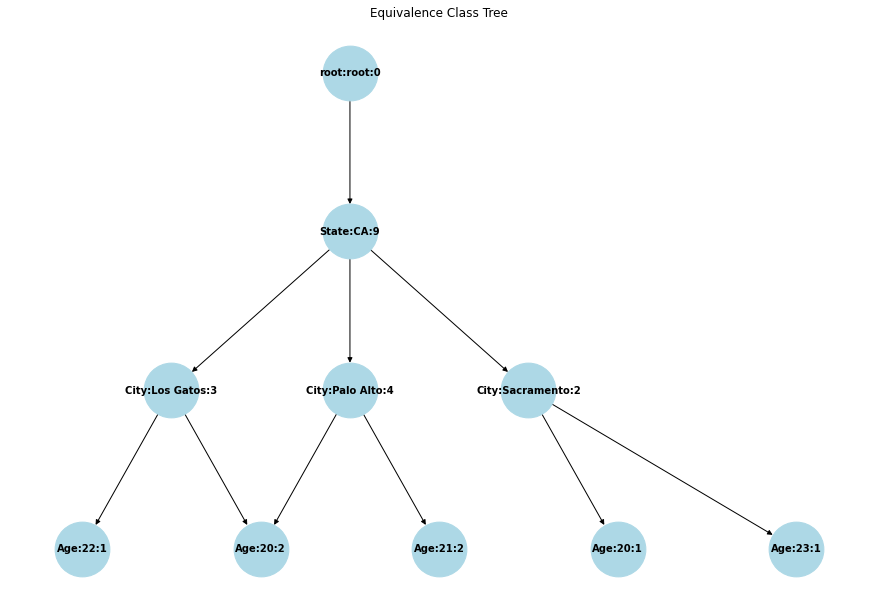

In [2]:
# Example creating a tree
rows = [
    ["CA", "Los Gatos", "20"],
    ["CA", "Los Gatos", "22"],
    ["CA", "Los Gatos", "20"],
    ["CA", "Palo Alto", "20"],
    ["CA", "Palo Alto", "21"],
    ["CA", "Palo Alto", "21"],
    ["CA", "Palo Alto", "20"],
    ["CA", "Sacramento", "20"],
    ["CA", "Sacramento", "23"],
]
    
df = pd.DataFrame(rows, columns = ["State", "City", "Age"])

tree = df_to_tree(df, ["State", "City", "Age"])
tree.draw()

In [3]:
# Example of the output from saving
tree.save_to_dict()

{'layers': ['State', 'City', 'Age'],
 'root': {'attribute': ('root', 'root'),
  'size': 0,
  'child_nodes': {('State', 'CA'): {'attribute': ('State', 'CA'),
    'size': 9,
    'child_nodes': {('City', 'Los Gatos'): {'attribute': ('City', 'Los Gatos'),
      'size': 3,
      'child_nodes': {('Age', '20'): {'attribute': ('Age', '20'),
        'size': 2,
        'child_nodes': {}},
       ('Age', '22'): {'attribute': ('Age', '22'),
        'size': 1,
        'child_nodes': {}}}},
     ('City', 'Palo Alto'): {'attribute': ('City', 'Palo Alto'),
      'size': 4,
      'child_nodes': {('Age', '20'): {'attribute': ('Age', '20'),
        'size': 2,
        'child_nodes': {}},
       ('Age', '21'): {'attribute': ('Age', '21'),
        'size': 2,
        'child_nodes': {}}}},
     ('City', 'Sacramento'): {'attribute': ('City', 'Sacramento'),
      'size': 2,
      'child_nodes': {('Age', '20'): {'attribute': ('Age', '20'),
        'size': 1,
        'child_nodes': {}},
       ('Age', '23'): {'at

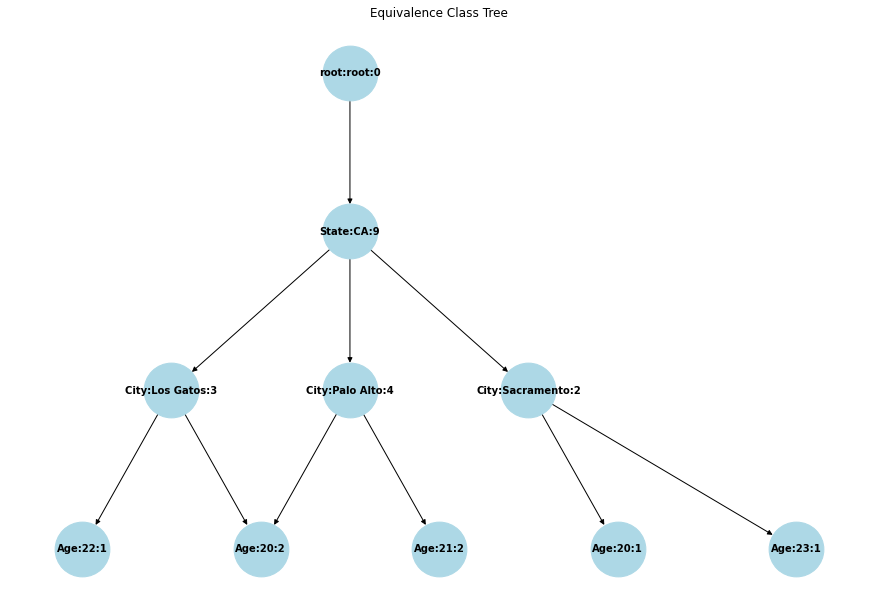

In [4]:
# Example reloading from the saved dict
reloaded = EquivalenceClassTree.load_from_dict(tree.save_to_dict())
reloaded.draw()

In [5]:
# Try loading a legit dataset to see what happens (will send you this random dataset I got from internet)
df = pd.read_csv("/Users/dylanmoradpour/Desktop/NYSDOH_BRFSS_SurveyData_2015.csv", encoding='cp1252')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (183,378) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Continous fields would be binned to define equivalence classes, ignore them for now
df_cat = df.select_dtypes(exclude=[np.number])

# Get columns that arent too deep so we can visualize easily (plotting is pretty basic)
low_depth_cols = df_cat.columns[(df_cat.nunique() > 2) & (df_cat.nunique() < 5)]

In [7]:
# Create a tree w/ just a few columns so the viz isnt insane
tree = df_to_tree(df, low_depth_cols[0:5])

100%|█████████████████████████████████| 12357/12357 [00:00<00:00, 184733.50it/s]


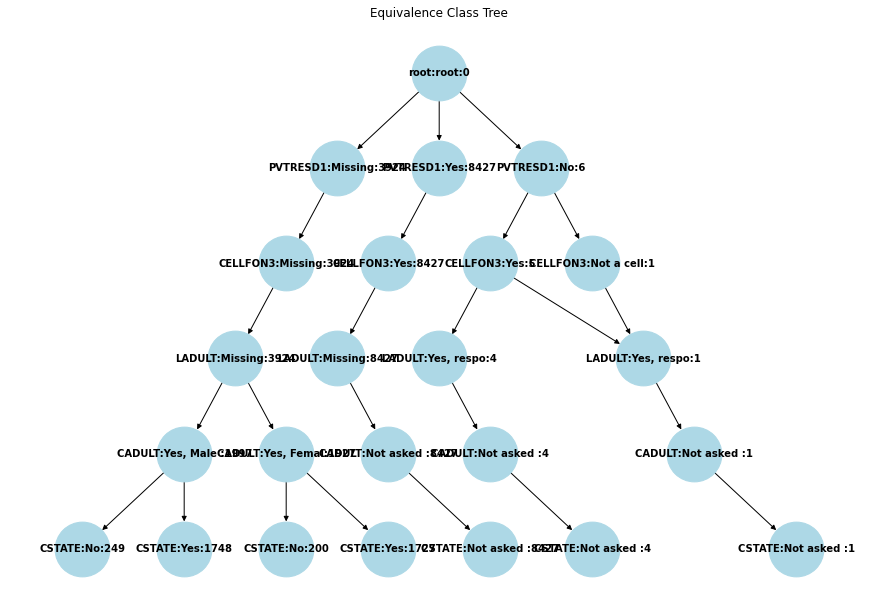

In [8]:
tree.draw()

In [9]:
# Stress test performance to make sure it won't bust a pipeline - this is super wide so very deep trees
print(df_cat.shape)
tree = df_to_tree(df_cat, df_cat.columns)

(12357, 313)


100%|███████████████████████████████████| 12357/12357 [00:12<00:00, 1020.66it/s]


In [ ]:
# Use this tree to derive useful signals from the leaf nodes - specifically look at equivalence class
# sizes (perhaps % of people in "small" classes?).